In [3]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
import imghdr
from tensorflow.keras import models, layers
from IPython.display import HTML

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

In [5]:
trainingdataset=tf.keras.preprocessing.image_dataset_from_directory('Training Dataset',
seed=1234,
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)

Found 7222 files belonging to 4 classes.


In [6]:
class_names = trainingdataset.class_names
class_names

['Black Rot', 'Esca (Black Measles)', 'Healthy', 'Leaf Blight']

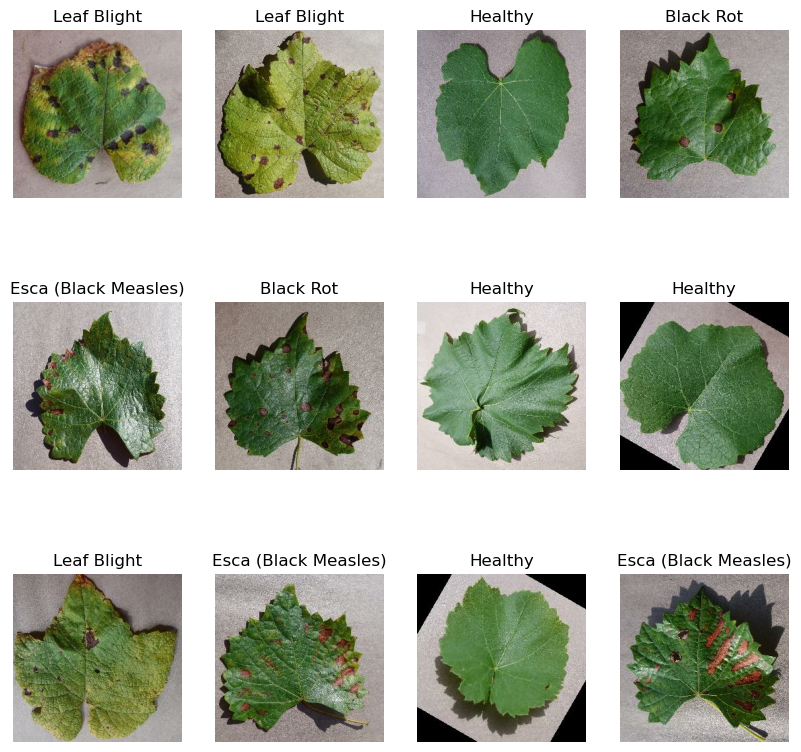

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in trainingdataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(trainingdataset)

226

In [9]:
train_size = 0.2
len(trainingdataset)*train_size

45.2

In [16]:
train_ds = trainingdataset.take(45)
len(train_ds)

45

In [17]:
test_ds = trainingdataset.skip(45)
len(test_ds)

181

In [18]:
val_size=0.2
len(trainingdataset)*val_size

45.2

In [19]:
val_ds = trainingdataset.take(45)
len(val_ds)

45

In [20]:
len(train_ds)

45

In [21]:
len(test_ds)

181

In [22]:
len(val_ds)

45

In [23]:
def get_dataset_partitions_tf(ds, train_split=0.2, val_split=0.2, test_split=0.6, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(trainingdataset)

In [25]:
len(train_ds)

45

In [26]:
len(val_ds)

45

In [27]:
len(test_ds)

136

In [28]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [30]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [31]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 128)        

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
45/45 [==============================] - 92s 2s/step - loss: 0.9073 - accuracy: 0.6132 - val_loss: 2.1163 - val_accuracy: 0.4308
Epoch 2/5
45/45 [==============================] - 78s 2s/step - loss: 0.4834 - accuracy: 0.8285 - val_loss: 0.6984 - val_accuracy: 0.7573
Epoch 3/5
45/45 [==============================] - 77s 2s/step - loss: 0.3985 - accuracy: 0.8410 - val_loss: 0.7988 - val_accuracy: 0.7580
Epoch 4/5
45/45 [==============================] - 77s 2s/step - loss: 0.2881 - accuracy: 0.8806 - val_loss: 0.7702 - val_accuracy: 0.8084
Epoch 5/5
45/45 [==============================] - 77s 2s/step - loss: 0.2681 - accuracy: 0.8910 - val_loss: 0.8504 - val_accuracy: 0.7776


In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
scores = model.evaluate(test_ds)

136/136 [==============================] - 51s 285ms/step - loss: 0.9573 - accuracy: 0.7562


In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

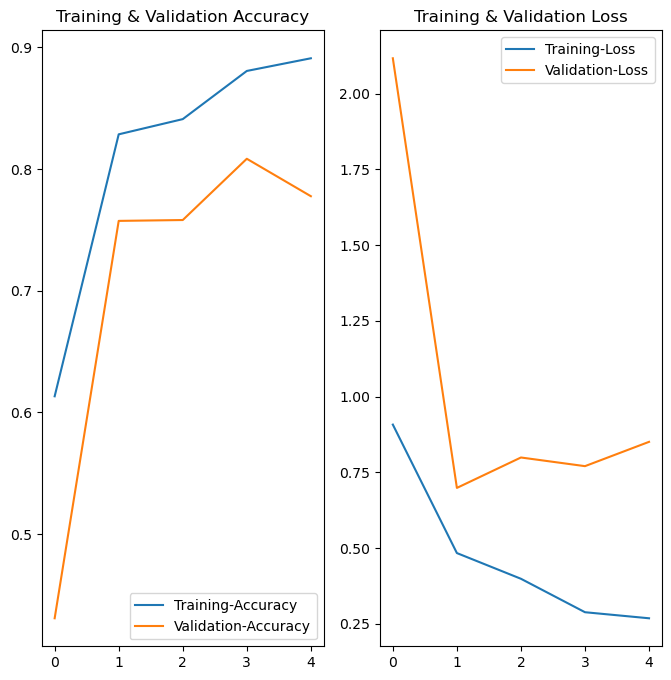

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training-Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation-Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training-Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation-Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.show()

In [42]:
from sklearn import metrics
import numpy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score , precision_score , f1_score

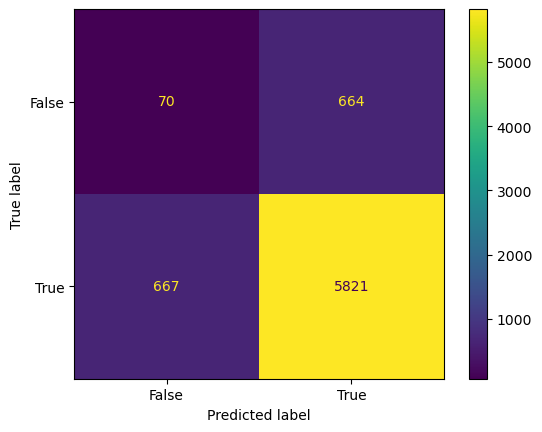

In [47]:
actual = numpy.random.binomial(1,.9,size = 7222)
predicted = numpy.random.binomial(1,.9,size = 7222)
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
Accuracy1 = metrics.accuracy_score(actual, predicted)

cm_display.plot()
plt.show()

In [48]:
accuracy_score(actual , predicted)

0.8157020216006646

In [49]:
precision_score(actual , predicted)

0.8976098689282961

In [50]:
f1_score(actual , predicted)

0.8974022970785478